=== STEP 1: DATA ACQUISITION & GEOMETRY FIXING ===
Loading GeoJSON from: https://opendata.wuerzburg.de/api/explore/v2.1/catalog/datasets/stadtbezirke/exports/geojson?refine=name:Sanderau
Geometry validity check: Valid Geometry

=== STEP 2: GRAPH EXTRACTION & CLEANING ===
Extracting drive network from OSM...
Final graph constructed: 119 nodes, 284 edges.
Displaying network plot...


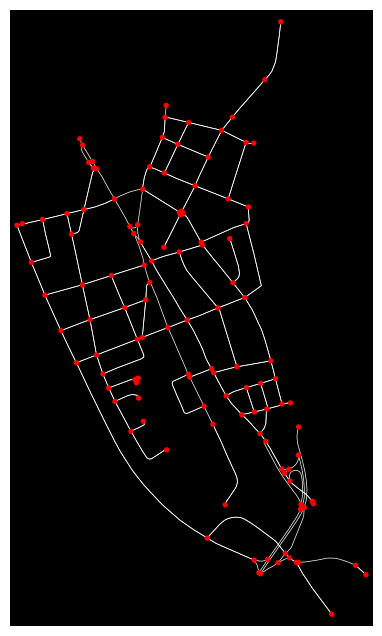


=== STEP 3: FEATURE ENGINEERING (GROUND TRUTH) ===
Calculating Eccentricity (Target Value) using NetworkX...
[NodeID in OpenStreetMap] : [Eccentricity]
{10799942: 19, 10799945: 18, 27353886: 18, 27271153: 17, 10799947: 18, 10799949: 19, 33176377: 20, 27255596: 20, 10799953: 17, 27411442: 17, 27411445: 18, 21273715: 12, 27489442: 13, 27495799: 13, 28099467: 13, 1979806832: 11, 21273717: 22, 28099579: 21, 21273732: 17, 247718678: 16, 21273747: 13, 28099532: 14, 1278485110: 14, 28099534: 14, 25584361: 14, 27489425: 15, 27489426: 13, 25584362: 16, 27489165: 15, 27253556: 14, 27489171: 13, 27489162: 13, 27353878: 16, 27353890: 19, 27432604: 16, 27511265: 16, 3539150693: 17, 6089366600: 15, 27432614: 17, 27511269: 16, 27432617: 15, 28099539: 14, 27432618: 15, 28099537: 14, 27432633: 18, 27489435: 17, 27471738: 15, 1979806812: 14, 27489161: 14, 28099549: 14, 27489168: 13, 27489166: 12, 27489164: 13, 27489170: 14, 27489174: 12, 1979806841: 12, 27489172: 14, 27489169: 13, 27489444: 12, 2748916

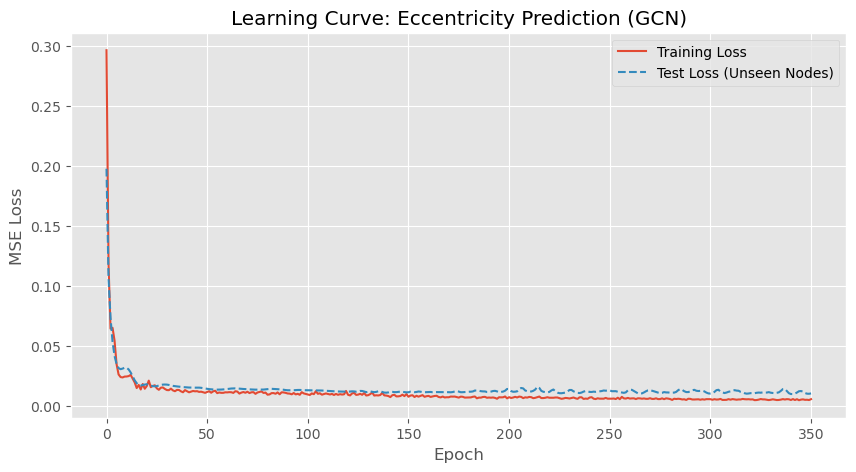


=== PROCESS COMPLETE ===

Generating prediction heatmap...
>> Heatmap saved as 'heatmap_prediction.png'


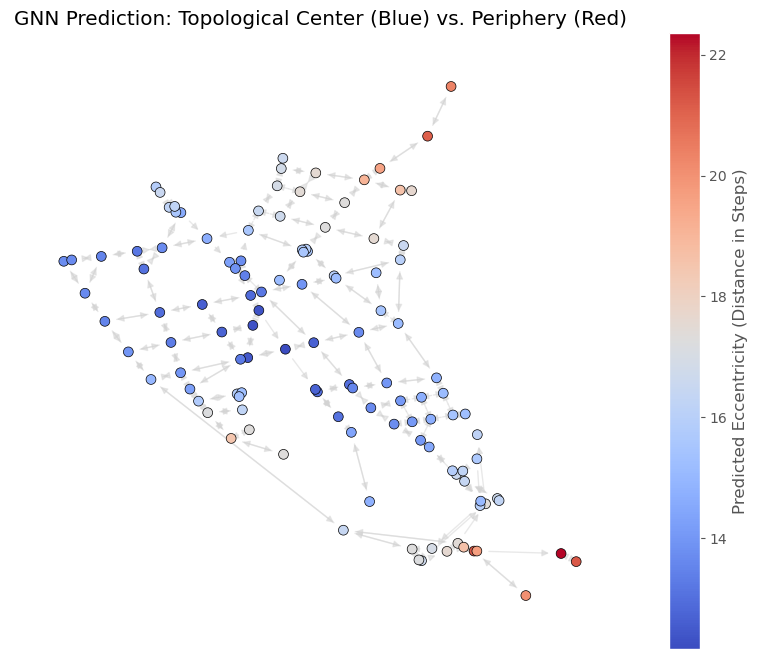

In [21]:
import geopandas as gpd
import osmnx as ox
import networkx as nx
import shapely.wkt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from shapely.validation import make_valid, explain_validity
from shapely.ops import unary_union
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Configuration for scientific plotting style
plt.style.use('ggplot')

print("=== STEP 1: DATA ACQUISITION & GEOMETRY FIXING ===")

# 1. Load data from Würzburg Open Data Portal
URL = "https://opendata.wuerzburg.de/api/explore/v2.1/catalog/datasets/stadtbezirke/exports/geojson?refine=name:Sanderau"
print(f"Loading GeoJSON from: {URL}")

# Load directly into WGS84 (EPSG:4326)
gdf_wgs = gpd.read_file(URL).to_crs(4326)

# Repair invalid geometries (Zero-Buffer technique)
gdf_wgs = gdf_wgs.explode(index_parts=False).reset_index(drop=True)
gdf_wgs["geometry"] = gdf_wgs.geometry.apply(make_valid).buffer(0)
poly = unary_union(gdf_wgs.geometry)

print(f"Geometry validity check: {explain_validity(poly)}")

print("\n=== STEP 2: GRAPH EXTRACTION & CLEANING ===")

# Load street network from OpenStreetMap (Type: 'drive')
print("Extracting drive network from OSM...")
G = ox.graph_from_polygon(poly, network_type="drive")

# Project graph to metric system (EPSG:25832 - UTM Zone 32N)
G = ox.project_graph(G, to_crs="EPSG:25832")

# Keep only the Largest Connected Component (remove isolated subgraphs)
G_undirected = G.to_undirected()
if not nx.is_connected(G_undirected):
    print("Removing disconnected graph components...")
    largest_cc = max(nx.connected_components(G_undirected), key=len)
    G = G.subgraph(largest_cc).copy()

# Homogenize attributes (Zero-Imputation for missing keys)
all_attributes = set()
for n, data in G.nodes(data=True):
    all_attributes.update(data.keys())

for n, data in G.nodes(data=True):
    for attribute in all_attributes:
        if attribute not in data:
            data[attribute] = 0.0

# Ensure correct data types (Force Float for coordinates)
for node, data in G.nodes(data=True):
    data['x'] = float(data['x'])
    data['y'] = float(data['y'])

print(f"Final graph constructed: {len(G.nodes())} nodes, {len(G.edges())} edges.")

# DISPLAY PLOT 1: The Network Visualization
print("Displaying network plot...")
fig, ax = ox.plot_graph(
    G,
    node_color="red",
    node_size=15,
    edge_color="white",
    edge_linewidth=0.5,
    bgcolor="black",
    show=True  # Changed to True to display inline
)

print("\n=== STEP 3: FEATURE ENGINEERING (GROUND TRUTH) ===")

print("Calculating Eccentricity (Target Value) using NetworkX...")
# Calculate eccentricity on undirected graph variant
ecc_dict = nx.eccentricity(G.to_undirected())

print("[NodeID in OpenStreetMap] : [Eccentricity]")
print(ecc_dict) 


# Angenommen G ist bereits geladen und bereinigt (aus Step 1 & 2)

print("\n=== STEP 3: ADVANCED GRAPH ANALYSIS (Centrality & Reach) ===")

# 1. Degree Centrality (Lokal)
# Maß für direkte Vernetzung
print("\nComputing Degree Centrality...")
deg_dict = nx.degree_centrality(G)
print(deg_dict)

# 2. Betweenness Centrality (Global)
# Maß für Brückenfunktion (Flaschenhälse)
print("\nComputing Betweenness Centrality...")
bet_dict = nx.betweenness_centrality(G, weight='length') 
# Tipp: weight='length' nutzt die tatsächliche Distanz, nicht nur Hops!
print(bet_dict)

# 3. Closeness Centrality (Global)
# Maß für Fahrgeschwindigkeit zu allen anderen Punkten
print("\nComputing Closeness Centrality...")
clo_dict = nx.closeness_centrality(G, distance='length')
print(clo_dict)




print("\n=== STEP 4: PYTORCH TENSOR CONSTRUCTION (Feature Stacking) ===")

# Create Mapping
node_list = list(G.nodes())
mapping = {old_id: new_id for new_id, old_id in enumerate(node_list)}



# Create canonical mapping (Old OSM-ID -> Index 0..N)
node_list = list(G.nodes())
mapping = {old_id: new_id for new_id, old_id in enumerate(node_list)}

print("\n=== STEP 4: PYTORCH TENSOR CONSTRUCTION ===")

# A. Node Features (x): Normalized Coordinates
x_coords = [G.nodes[n]['x'] for n in node_list]
y_coords = [G.nodes[n]['y'] for n in node_list]

# Z-Score Normalization (Standardization)
x_mean, x_std = np.mean(x_coords), np.std(x_coords)
y_mean, y_std = np.mean(y_coords), np.std(y_coords)
features = [[(x - x_mean)/x_std, (y - y_mean)/y_std] for x, y in zip(x_coords, y_coords)]
x = torch.tensor(features, dtype=torch.float)

# B. Edge Index (Connectivity List)
u_list, v_list = [], []
for u, v in G.edges():
    u_list.append(mapping[u])
    v_list.append(mapping[v])
edge_index = torch.tensor([u_list, v_list], dtype=torch.long)

# C. Target Values (y): Normalized Eccentricity
y_raw = [ecc_dict[n] for n in node_list]
y_tensor = torch.tensor(y_raw, dtype=torch.float)

# Min-Max Normalization to [0, 1] range
y_min, y_max = y_tensor.min(), y_tensor.max()
y = (y_tensor - y_min) / (y_max - y_min)
y = y.view(-1, 1) # Reshape to [N, 1]

# D. Train/Test Split (70/30 random split)
num_nodes = len(node_list)
perm = torch.randperm(num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[perm[:int(0.7 * num_nodes)]] = True
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[perm[int(0.7 * num_nodes):]] = True

# Construct PyG Data Object
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)
print("PyTorch Geometric Data Object created:", data)

print("\n=== STEP 5: GNN MODEL DEFINITION & TRAINING ===")

# Define Graph Convolutional Network (Regression)
class EccentricityGCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Input dim: 2 (x, y coordinates)
        # Hidden dim: 32 units
        self.conv1 = GCNConv(2, 32)
        self.conv2 = GCNConv(32, 32)
        # Output dim: 1 scalar (Eccentricity)
        self.conv3 = GCNConv(32, 1) 

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # Layer 1 + ReLU + Dropout
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        # Layer 2 + ReLU
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # Layer 3 (Output)
        x = self.conv3(x, edge_index)
        return x

# Setup training environment
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EccentricityGCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss() # Mean Squared Error for regression

train_losses = []
test_losses = []

print(f"Starting training on device: {device} for 350 epochs...")

# Training Loop
for epoch in range(351):
    model.train()
    optimizer.zero_grad()
    
    out = model(data)
    # Calculate loss only on training nodes using masks
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    # Validation step
    model.eval()
    with torch.no_grad():
        out_test = model(data)
        test_loss = criterion(out_test[data.test_mask], data.y[data.test_mask])
        test_losses.append(test_loss.item())

    if epoch % 50 == 0:
        print(f'Epoch {epoch:03d}: Train Loss: {loss.item():.5f}, Test Loss: {test_loss.item():.5f}')

# DISPLAY PLOT 2: Learning Curve
print("\nDisplaying Learning Curve...")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss (Unseen Nodes)", linestyle="--")
plt.title("Learning Curve: Eccentricity Prediction (GCN)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show() # Display plot inline

print("\n=== PROCESS COMPLETE ===")


# === STEP 6: HEATMAP VISUALIZATION ===
print("\nGenerating prediction heatmap...")

# 1. Make predictions for all nodes
model.eval()
with torch.no_grad():
    # Get raw model output (normalized 0-1)
    pred_normalized = model(data)

# 2. Denormalize (Convert back to real "Hops")
# Formula: value * (max - min) + min
pred_real = pred_normalized * (y_max - y_min) + y_min
pred_real = pred_real.numpy().flatten()

# 3. Create the Plot
plt.figure(figsize=(10, 8))

# A. Background: Draw all streets (edges) in light gray
# We need the positions for NetworkX
pos = {n: (G.nodes[n]['x'], G.nodes[n]['y']) for n in G.nodes()}
nx.draw_networkx_edges(G, pos, edge_color="lightgray", alpha=0.5)

# B. Foreground: Draw nodes colored by prediction
# We extract coordinates in the exact order of 'node_list' to match predictions
x_vals = [G.nodes[n]['x'] for n in node_list]
y_vals = [G.nodes[n]['y'] for n in node_list]

# cmap='coolwarm': Blue = Low Value (Center), Red = High Value (Periphery)
sc = plt.scatter(x_vals, y_vals, c=pred_real, cmap='coolwarm', 
                 s=50, zorder=2, edgecolors='black', linewidth=0.5)

# C. Legend and Layout
cbar = plt.colorbar(sc)
cbar.set_label("Predicted Eccentricity (Distance in Steps)")
plt.title("GNN Prediction: Topological Center (Blue) vs. Periphery (Red)")
plt.axis('off')

# Save and Show
plt.savefig("heatmap_prediction.png", dpi=300, bbox_inches='tight')
print(">> Heatmap saved as 'heatmap_prediction.png'")
plt.show()